# 1. IMPORTINGS

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

# 2. READ IMAGES

In [2]:
!unrar x data1.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from data1.rar

Creating    data1                                                     OK
Creating    data1/Cancer_L1                                           OK
Extracting  data1/Cancer_L1/10.PNG                                         0%  OK 
Extracting  data1/Cancer_L1/101.PNG                                        0%  OK 
Extracting  data1/Cancer_L1/103.PNG                                        1%  OK 
Extracting  data1/Cancer_L1/111.PNG                                        1%  OK 
Extracting  data1/Cancer_L1/113.PNG                                        1%  OK 
Extracting  data1/Cancer_L1/116.png                                        2%  OK 
Extracting  data1/Cancer_L1/118.png                                        2%  OK 
Extracting  data1/Cancer_L1/13.png                                         2%  OK 
Extracting  dat

In [3]:
path = "data1"

In [4]:
os.listdir(path)

['Cancer_L2', 'Normal', 'Cancer_L3', 'Cancer_L4', 'Cancer_L1']

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.listdir(path+'/Normal')[:10]

['N_1 (190).png',
 'N_1 (162).png',
 'N_1 (185).png',
 'N_1 (97).PNG',
 'N_1 (87).png',
 'N_1 (152).png',
 'N_1 (178).png',
 'N_1 (27).PNG',
 'N_1 (48).PNG',
 'N_1 (44).PNG']

In [7]:
class_names = os.listdir(path)

In [8]:
input_shape = (256,256)

In [9]:
for data_class in class_names:
    class_path = os.path.join(path, data_class)
    max_values = []
    min_values = []
    for image in os.listdir(class_path):
        img = imread(os.path.join(class_path, image))
        max_val = img.max()
        min_val = img.min()
        max_values.append(max_val)
        min_values.append(min_val)
    max_class_val = max(max_values)
    min_class_val = min(min_values)
    print("***************************")
    print(f"Class: {data_class}")
    print(f"Max value: {max_class_val}")
    print(f"Min value: {min_class_val}")

print("***************************")

***************************
Class: Cancer_L2
Max value: 1.0
Min value: 0.0
***************************
Class: Normal
Max value: 1.0
Min value: 0.0
***************************
Class: Cancer_L3
Max value: 1.0
Min value: 0.0
***************************
Class: Cancer_L4
Max value: 1.0
Min value: 0.0
***************************
Class: Cancer_L1
Max value: 1.0
Min value: 0.0
***************************


So you can see data is not scaled

# 3. TRAIN-VALIDATION SPLIT

In [10]:
batch_size = 64

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=input_shape,
  batch_size=batch_size)

Found 296 files belonging to 5 classes.
Using 237 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=input_shape,
  batch_size=batch_size)

Found 296 files belonging to 5 classes.
Using 59 files for validation.


**See** different split techniques at : https://www.kaggle.com/code/eneskosar19/image-classification-pipeline-tensorflow

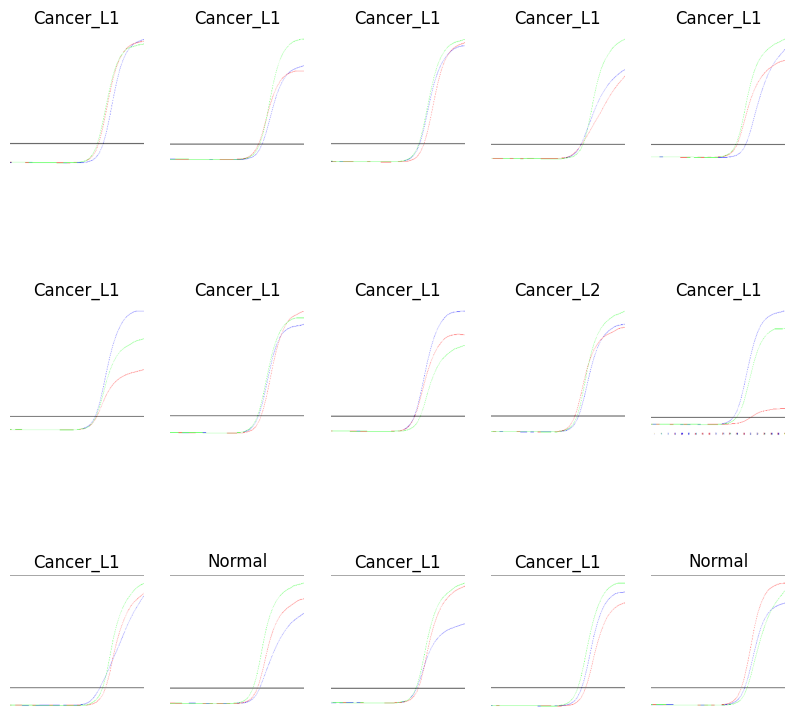

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 3.1. CACHE AND PREFETCH

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

1. **Caching**: Stores data in memory after first load (both training and validation). This dramatically reduces disk access time, significantly speeding up training, especially for large datasets.

2. **Shuffling** (training only): Randomizes data order to prevent overfitting. This helps the model learn general patterns from the data, leading to better performance on unseen examples.
  
3. **Prefetching with Autotune** (both): Overlaps data prep with model training, using optimal buffer size based on your hardware. This hides data processing latency, allowing the model to work continuously and potentially reducing training time.

# 4. SCALING

**Importance of Data Set Scaling**
Data set scaling is a crucial step in TensorFlow that can significantly speed up model training. Especially when working with large datasets, this process can dramatically impact the model's convergence time and overall performance.

**Benefits of Scaling:**

1. Faster Training: Scaling can significantly reduce training time by increasing the model's access and processing speed of the dataset. This leads to faster results and shorter development cycles.
2. Enhanced Performance: A proper scaling strategy can optimize overall performance by helping the model learn patterns in the dataset more efficiently.
3. Memory Efficiency: Data set scaling can help the model occupy less memory, which is crucial especially when working with large datasets.
4. Overall Resource Optimization: Proper scaling can ensure more efficient use of CPU, GPU, and other hardware resources, optimizing overall system performance.

In [15]:
train_ds = train_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))

In [16]:
image_batch, labels_batch = next(iter(train_ds)) #This is how you read image batches, each batch contains 64 images and 64 related labels

In [17]:
first_image = image_batch[0]

In [18]:
print(np.min(first_image), np.max(first_image))

0.0 1.0


Now it's scaled

# 5.1 CREATE MODEL

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,BatchNormalization

In [20]:
input_shape =  (256,256,3) #Add extra dimension "3" because it represent RGB(Colored Image)

In [21]:
num_classes = len(class_names)
num_classes

5

In [22]:
model = Sequential()

model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
#ANN

model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# 5.2 COMPILE

In [23]:
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0

# 5.3 FIT

Let's get the insights about the model

In [25]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
4/4 [==============================] - 11s 1s/step - loss: 1.3525 - accuracy: 0.5148 - val_loss: 1.1445 - val_accuracy: 0.7288
Epoch 2/10
4/4 [==============================] - 0s 85ms/step - loss: 1.1349 - accuracy: 0.6624 - val_loss: 0.9664 - val_accuracy: 0.7288
Epoch 3/10
4/4 [==============================] - 0s 78ms/step - loss: 1.1138 - accuracy: 0.6624 - val_loss: 1.0088 - val_accuracy: 0.7288
Epoch 4/10
4/4 [==============================] - 0s 84ms/step - loss: 1.1091 - accuracy: 0.6624 - val_loss: 0.9697 - val_accuracy: 0.7288
Epoch 5/10
4/4 [==============================] - 0s 83ms/step - loss: 1.1055 - accuracy: 0.6624 - val_loss: 0.9775 - val_accuracy: 0.7288
Epoch 6/10
4/4 [==============================] - 0s 89ms/step - loss: 1.1076 - accuracy: 0.6624 - val_loss: 0.9966 - val_accuracy: 0.7288
Epoch 7/10
4/4 [==============================] - 0s 87ms/step - loss: 1.0954 - accuracy: 0.6624 - val_loss: 0.9598 - val_accuracy: 0.7288
Epoch 8/10
4/4 [============

# 5.4 INSIGHTS AFTER FIRST FIT

1. While accuracy increasing , val_accuracy started to decrease  -> Maybe Overfitting ??

2. While loss is decreasing , val_loss started to increase --> Overfitting ??

3. After a while, the difference between train and validation started to get bigger --> OVERFIT

What is overfitting,you can basically say that model tries to memorize instead of learning, so train scores are too high,test scores will be to low.
Model will mispredict the datas which it didn't see.

See detailed description here : https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

# 5.5 VISUALIZE THE TRAIN RESULTS

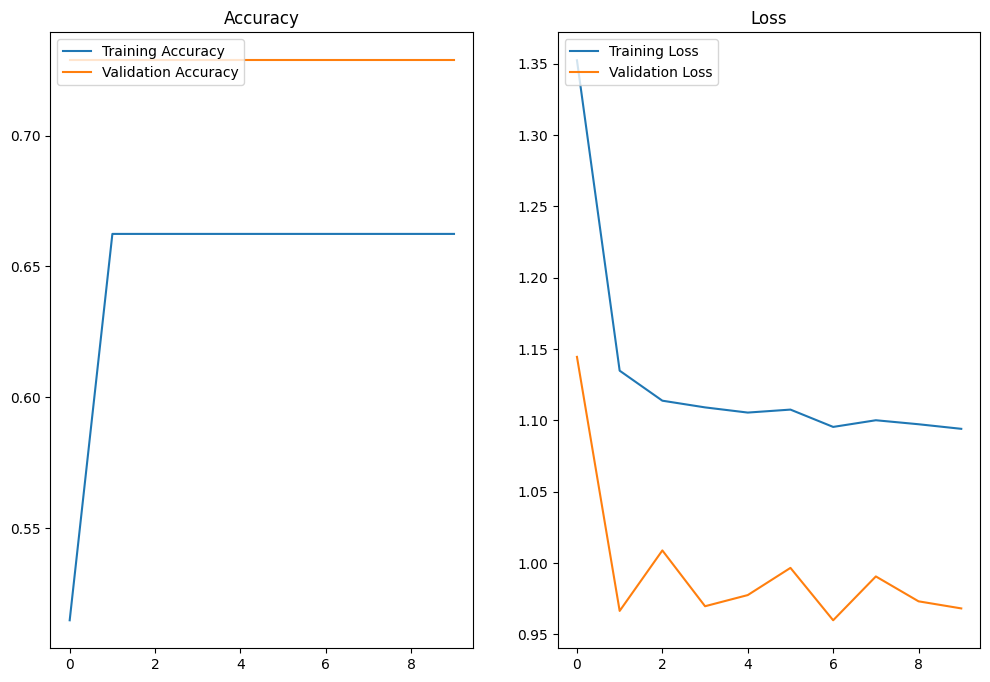

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss')
plt.show()

So we can see it's overfit while val_los is increasing,train_los is decrease

# 6. DEAL WITH OVERFITTING

How to deal with overfitting ?

To combat overfitting in deep learning, we have several powerful techniques:

**Data Augmentation:** This artificially expands the training data by creating variations of existing data (e.g., rotating images, adding noise). This exposes the model to a wider range of scenarios, improving its ability to generalize to unseen data and reducing overfitting.

**Batch Normalization:** This stabilizes the training process by normalizing the activations of hidden layers, making the model less sensitive to initialization values and allowing for faster learning.

**Early Stopping:** This technique monitors the model's performance on a validation set. If the validation performance stops improving, training is halted to prevent the model from memorizing irrelevant details in the training data.

**Dropout:** This injects randomness by randomly dropping out neurons during training. This forces the model to learn robust features that are not dependent on any specific neuron, ultimately reducing overfitting.


See more techniques here : https://towardsdatascience.com/8-simple-techniques-to-prevent-overfitting-4d443da2ef7d

See detailed augmentation tutorial here : https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9

We will not be using data augmentation because it is increasing data and fit time, but you can try

# 6.1 DROPOUT - BATCH NORMALIZATION

In [27]:
from tensorflow.keras.optimizers import Adam

In [28]:
model = Sequential()


model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0,2))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
#ANN

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0,2))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [29]:
model.compile(optimizer=Adam(learning_rate=0.003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)       

# 6.2 REDUCE LEARNING RATE

In [31]:
batch_size=64

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)

In [32]:
class GetBestModel(tf.keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [33]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)

# 6.3 EARLY STOPPING

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [36]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=batch_size,
  callbacks=[early_stop,red_lr,best_model]
)

Epoch 1/25
4/4 [==============================] - 5s 408ms/step - loss: 1.5240 - accuracy: 0.3291 - val_loss: 5.4931 - val_accuracy: 0.0678 - lr: 0.0030
Epoch 2/25
4/4 [==============================] - 0s 93ms/step - loss: 1.0885 - accuracy: 0.6920 - val_loss: 22.6227 - val_accuracy: 0.0678 - lr: 0.0030
Epoch 3/25
4/4 [==============================] - 0s 91ms/step - loss: 0.8968 - accuracy: 0.7637 - val_loss: 13.2955 - val_accuracy: 0.7288 - lr: 0.0030
Epoch 4/25
4/4 [==============================] - 0s 96ms/step - loss: 0.7948 - accuracy: 0.7637 - val_loss: 28.2412 - val_accuracy: 0.7288 - lr: 0.0030
Epoch 5/25
4/4 [==============================] - 0s 92ms/step - loss: 0.7233 - accuracy: 0.7848 - val_loss: 49.7129 - val_accuracy: 0.0678 - lr: 0.0030
Epoch 6/25
4/4 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7553
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00030000000260770325.
4/4 [==============================] - 0s 100ms/step - loss: 0.668

**BEST PRACTİCES :**

I have tried like too many values for each component, here what I see :
**For this spesific model;**

1. Increasing the model complexity without increasing regularization parameters, overfits too fast
2. Decreasing the model layers and add more neurons,underfits.
3. Increasing learning rate to over 0,05 overfits.
4. Using Data augmentation with high parameters such as : rotation_range(0.5), underfits.
5. When you add regularization layers in order to avoid overfitting in high-layer structers, overfits after 20th-25th epoch.




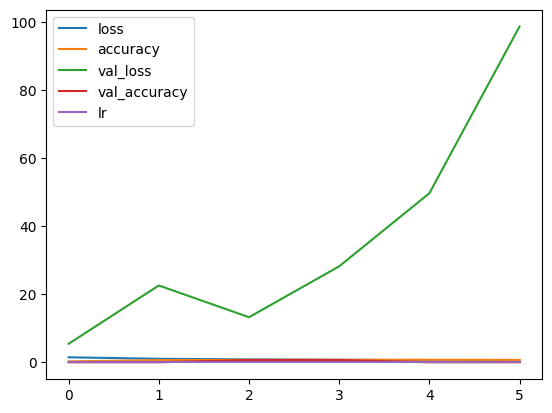

In [38]:
pd.DataFrame(history.history).plot();

# 7. TRANSFER LEARNİNG

In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import Xception

**Transfer Learning**

Transfer learning is a technique in deep learning where a pre-trained model on one task is leveraged to improve performance on a new, but related task. It's like having a seasoned student help a new student learn the ropes.

We use transfer learning because it offers several advantages:

**Faster Training:** Training a complex model from scratch can be time-consuming and require a massive amount of data. Transfer learning allows you to utilize the knowledge already captured in the pre-trained model, significantly reducing training time.
**Better Performance:** Pre-trained models are often trained on vast datasets, giving them a strong understanding of underlying concepts. By transferring this knowledge, you can achieve better results on your new task, even with a limited dataset.
**Reduced Resources:** Training complex models requires significant computational power. Transfer learning allows you to leverage the pre-trained model, reducing the computational resources needed for your new task.

**Overall**, transfer learning is a powerful tool that accelerates the development of machine learning models and improves their performance, making it a valuable technique in various applications.

# 7.1 Xception Model

See detailed source : https://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception

In [40]:
Xception_model = Sequential()

pretrained_model = Xception(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',
                   weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

Xception_model.add(pretrained_model)
Xception_model.add(Flatten())
#ANN
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(Dropout(0,2))

Xception_model.add(Dense(num_classes, activation='softmax'))

Xception_model.compile(optimizer=Adam(learning_rate=0.003),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Xception_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 2565      
                                                       

layer.trainable=False

**This code freezes the weights of all layers in the pre-trained model, preventing them from being updated during training.**

In [41]:
Xception_model_results = Xception_model.fit(train_ds, epochs=25,
                             validation_data=val_ds,
                             callbacks=[early_stop])


Epoch 1/25
4/4 [==============================] - 22s 4s/step - loss: 2.1092 - accuracy: 0.4008 - val_loss: 1.1164 - val_accuracy: 0.7288
Epoch 2/25
4/4 [==============================] - 1s 363ms/step - loss: 1.2559 - accuracy: 0.6709 - val_loss: 1.1750 - val_accuracy: 0.7797
Epoch 3/25
4/4 [==============================] - 1s 353ms/step - loss: 1.0617 - accuracy: 0.7131 - val_loss: 0.7239 - val_accuracy: 0.7966
Epoch 4/25
4/4 [==============================] - 1s 382ms/step - loss: 0.8456 - accuracy: 0.7468 - val_loss: 0.6981 - val_accuracy: 0.8136
Epoch 5/25
4/4 [==============================] - 1s 383ms/step - loss: 0.7248 - accuracy: 0.7426 - val_loss: 0.6487 - val_accuracy: 0.7966
Epoch 6/25
4/4 [==============================] - 1s 356ms/step - loss: 0.7298 - accuracy: 0.7342 - val_loss: 0.6154 - val_accuracy: 0.8136
Epoch 7/25
4/4 [==============================] - 1s 398ms/step - loss: 0.6641 - accuracy: 0.7553 - val_loss: 0.5861 - val_accuracy: 0.8475
Epoch 8/25
4/4 [======

W0000 00:00:1715013500.327696     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

These warnings are result of the XLA and JIT compile nuances in the background.You don't have to worry about.

Accelerated Linear Algebra(XLA)
Just In Time(JIT)

see detailed discussion : https://github.com/keras-team/keras/issues/19081

# 7.2 MobileNetV2 Model

See detailed source : https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2

In [42]:
early_stop = EarlyStopping(monitor='val_loss',patience=20) #increased the patience of early stoping

In [43]:
MobileNetV2_model = Sequential()

pretrained_model = MobileNetV2(include_top=False,
                   input_shape=(256, 256, 3),
                   pooling='avg',
                   weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

MobileNetV2_model.add(pretrained_model)
MobileNetV2_model.add(Flatten())
# ANN
MobileNetV2_model.add(Dense(512, activation='relu'))
MobileNetV2_model.add(Dense(256, activation='relu'))
MobileNetV2_model.add(Dropout(0,2))

MobileNetV2_model.add(Dense(32, activation='relu'))



MobileNetV2_model.add(Dense(num_classes, activation='softmax'))

MobileNetV2_model.compile(optimizer=Adam(learning_rate=0.003),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                          metrics=['accuracy'])

MobileNetV2_model.summary()


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                82

In [44]:
MobileNetV2_model_results = MobileNetV2_model.fit(train_ds, epochs=50,
                             validation_data=val_ds,
                             callbacks=[early_stop])

Epoch 1/50
4/4 [==============================] - 9s 1s/step - loss: 1.7600 - accuracy: 0.5105 - val_loss: 3.3113 - val_accuracy: 0.0678
Epoch 2/50
4/4 [==============================] - 1s 153ms/step - loss: 2.0441 - accuracy: 0.4135 - val_loss: 1.4251 - val_accuracy: 0.7288
Epoch 3/50
4/4 [==============================] - 1s 144ms/step - loss: 1.5338 - accuracy: 0.6624 - val_loss: 1.1733 - val_accuracy: 0.7966
Epoch 4/50
4/4 [==============================] - 1s 134ms/step - loss: 1.3129 - accuracy: 0.6793 - val_loss: 1.0514 - val_accuracy: 0.7966
Epoch 5/50
4/4 [==============================] - 1s 134ms/step - loss: 1.1309 - accuracy: 0.7215 - val_loss: 1.0302 - val_accuracy: 0.7627
Epoch 6/50
4/4 [==============================] - 1s 145ms/step - loss: 1.0278 - accuracy: 0.7131 - val_loss: 0.8715 - val_accuracy: 0.7966
Epoch 7/50
4/4 [==============================] - 1s 131ms/step - loss: 0.9552 - accuracy: 0.7173 - val_loss: 0.8049 - val_accuracy: 0.7966
Epoch 8/50
4/4 [=======

# 8. COMPARISON - VISUALIZE THE TRAINING RESULTS

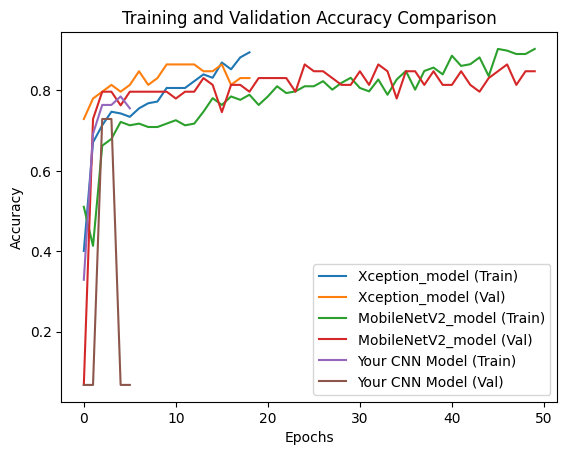

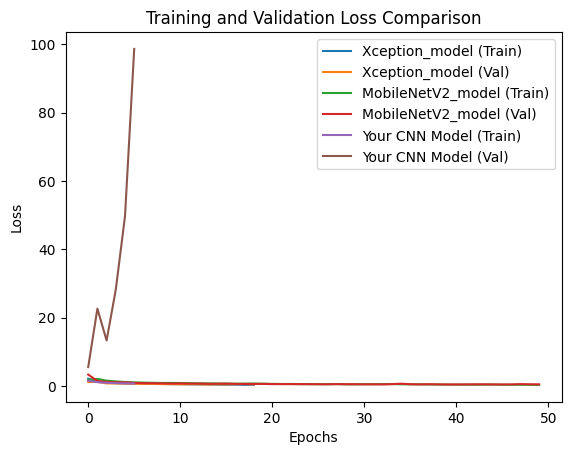

In [45]:

# Plotting accuracy
plt.plot(Xception_model_results.history['accuracy'], label='Xception_model (Train)')
plt.plot(Xception_model_results.history['val_accuracy'], label='Xception_model (Val)')
plt.plot(MobileNetV2_model_results.history['accuracy'], label='MobileNetV2_model (Train)')
plt.plot(MobileNetV2_model_results.history['val_accuracy'], label='MobileNetV2_model (Val)')
plt.plot(history.history['accuracy'], label='Your CNN Model (Train)')
plt.plot(history.history['val_accuracy'], label='Your CNN Model (Val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

# Plotting loss
plt.plot(Xception_model_results.history['loss'], label='Xception_model (Train)')
plt.plot(Xception_model_results.history['val_loss'], label='Xception_model (Val)')
plt.plot(MobileNetV2_model_results.history['loss'], label='MobileNetV2_model (Train)')
plt.plot(MobileNetV2_model_results.history['val_loss'], label='MobileNetV2_model (Val)')
plt.plot(history.history['loss'], label='Your CNN Model (Train)')
plt.plot(history.history['val_loss'], label='Your CNN Model (Val)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()


1/1 [==============================] - 0s 64ms/step
[[ 2  0  0  0  3]
 [ 0  1  0  0  3]
 [ 0  0  4  0  0]
 [ 0  0  0  3  0]
 [ 0  3  0  0 40]]


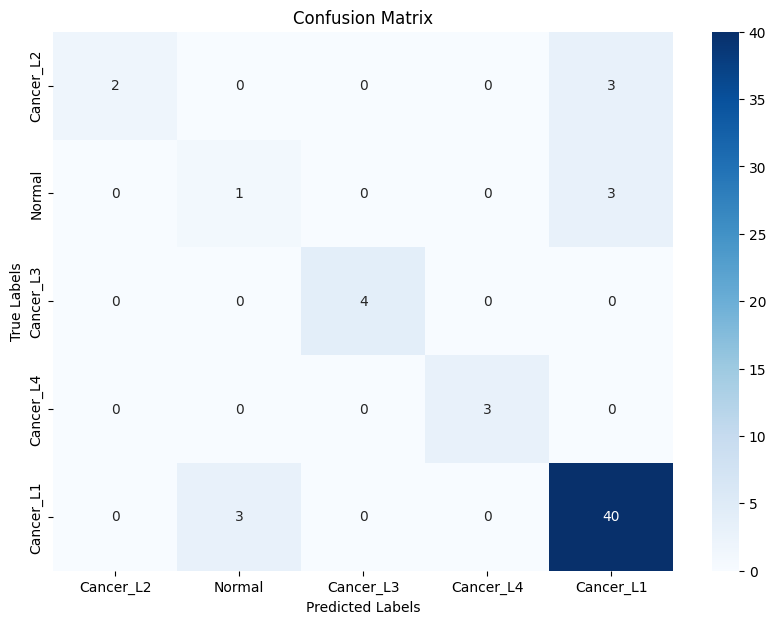

In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the labels for the validation set
y_pred = MobileNetV2_model.predict(val_ds)

# Convert the predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.concatenate([y for x, y in val_ds], axis=0) # Extract labels from the dataset

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 1s 741ms/step
[[ 2  1  0  0  2]
 [ 0  1  0  0  3]
 [ 0  0  4  0  0]
 [ 0  0  0  3  0]
 [ 0  4  0  0 39]]


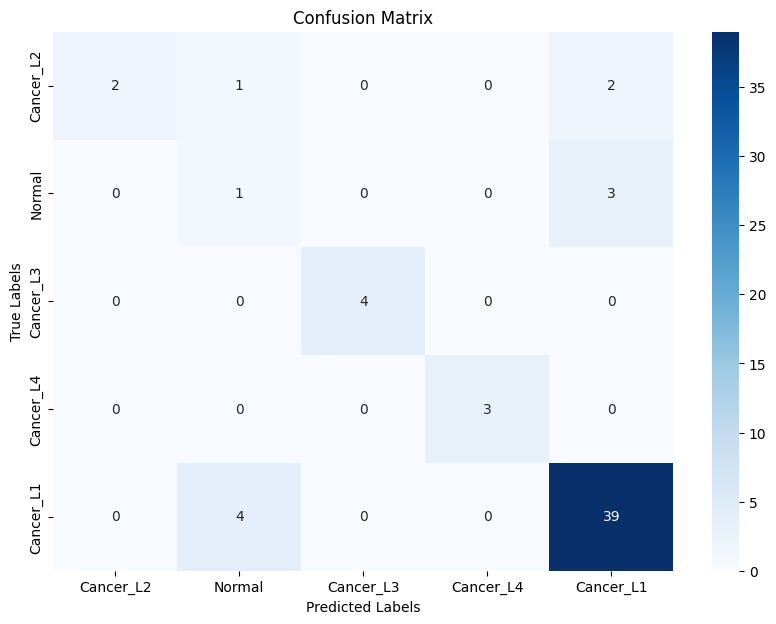

In [57]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the labels for the validation set
y_pred = Xception_model.predict(val_ds)

# Convert the predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.concatenate([y for x, y in val_ds], axis=0) # Extract labels from the dataset

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 146ms/step
[[ 0  0  5  0  0]
 [ 0  0  4  0  0]
 [ 0  0  4  0  0]
 [ 0  0  3  0  0]
 [ 0  0 43  0  0]]


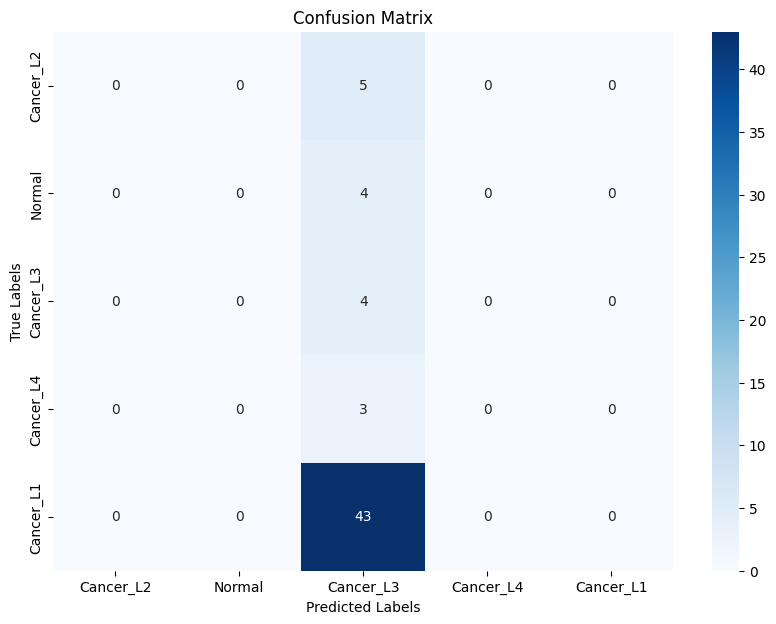

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predict the labels for the validation set
y_pred = model.predict(val_ds)

# Convert the predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the validation set
y_true = np.concatenate([y for x, y in val_ds], axis=0) # Extract labels from the dataset

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Print the confusion matrix
print(cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [62]:
# prompt: predict the label of a new image

import numpy as np
# Load the image
image = tf.keras.preprocessing.image.load_img(
    'test.PNG', target_size=(256, 256)
)

# Preprocess the image
image = tf.keras.preprocessing.image.img_to_array(image)
image = image / 255.0

# Make a prediction
prediction = MobileNetV2_model.predict(np.expand_dims(image, axis=0))

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(predicted_class_name)

# Make a prediction
prediction = Xception_model.predict(np.expand_dims(image, axis=0))

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(predicted_class_name)
# Make a prediction
prediction = model.predict(np.expand_dims(image, axis=0))

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

# Print the predicted class name
print(predicted_class_name)


1/1 [==============================] - 0s 23ms/step
Cancer_L4
1/1 [==============================] - 0s 22ms/step
Normal
1/1 [==============================] - 0s 18ms/step
Cancer_L3
